#Bonus Model For Assignment 3

In [ ]:
import keras
import cv2
import re
import numpy as np
import argparse
import os
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16,InceptionV3,InceptionResNetV2, DenseNet201, VGG19, ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from skimage.io import imread
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
import seaborn as sn
import itertools
from sklearn.metrics import precision_recall_fscore_support
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Add, Activation, Multiply, concatenate
from keras.callbacks import ReduceLROnPlateau
import tensorflow_addons as tfa
%matplotlib inline




##Change Path Here

In [309]:
#print(os.listdir('/content/drive/MyDrive/Colab Notebooks/HW3/'))
path ='/content/drive/MyDrive/Colab Notebooks/HW3/IML_CXR/'
path2 = '/content/drive/MyDrive/Colab Notebooks/HW3/cxr_label_train.csv'
path3 = '/content/drive/MyDrive/Colab Notebooks/HW3/IML_CXR_TEST/'
modelpath="/content/drive/MyDrive/Colab Notebooks/HW3/DenseNet_Results/best_finetuned(45)_densenet.h5"
filenames = os.listdir(path)


In [280]:
test_filenames = os.listdir(path3)

test_filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
final_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = final_df.shape[0]
final_df.head()

,filename
0,51.jpg
1,54.jpg
2,59.jpg
3,60.jpg
4,61.jpg


In [281]:

labels = pd.read_csv(path2)
id = labels.groupby('hospital_outcome')
print(id.size())
df = labels.copy()
label0 = id.get_group(0)
label_0 = label0['PATIENT ID']
label_0.to_numpy()
label1 = id.get_group(1)
label_1 = label1['PATIENT ID']
label_1.to_numpy()
df['PATIENT ID'] = df['PATIENT ID'].astype(str) + '.jpg'
df['hospital_outcome'] = df['hospital_outcome'].astype(str)

hospital_outcome
0    1229
1     164
dtype: int64


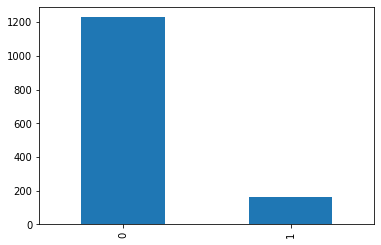

In [282]:
df['hospital_outcome'].value_counts().plot.bar()

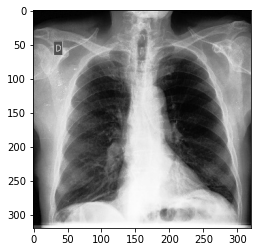

In [283]:
import random
sample = random.choice(filenames)
image = load_img(path+sample)
plt.imshow(image)

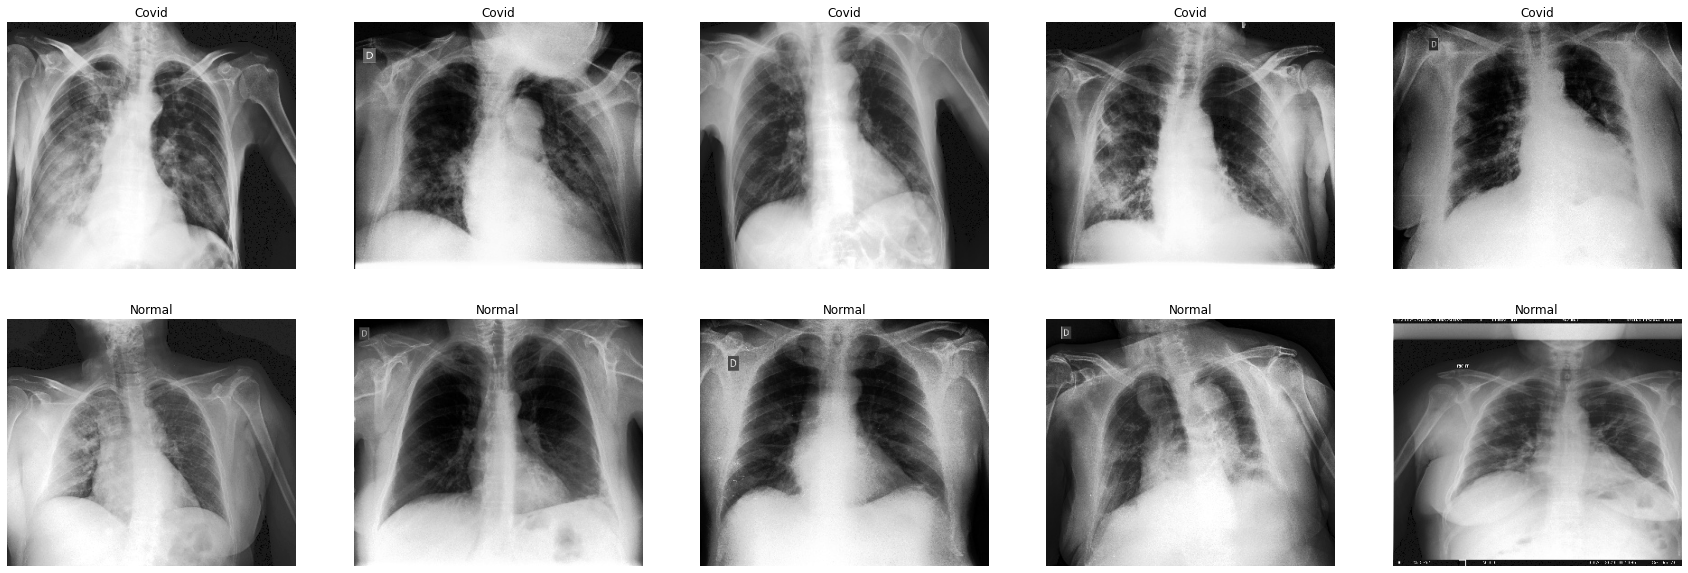

In [284]:
covid_samples = (df[df['hospital_outcome']=='1']['PATIENT ID'].iloc[:5]).tolist()
normal_samples = (df[df['hospital_outcome']=='0']['PATIENT ID'].iloc[:5]).tolist()

samples = covid_samples + normal_samples
del covid_samples, normal_samples


f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(path+samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Covid")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

##Data preprocessing

In [285]:
train_valid_df, test_df = train_test_split(df,test_size =0.1,stratify = df['hospital_outcome'] )
train_valid_df = train_valid_df.reset_index()
test_df = test_df.reset_index()
#print(test_df.groupby('hospital_outcome').size())
train_valid_df_size = train_valid_df.shape[0]
test_size = test_df.shape[0]

In [307]:
train_df, valid_df = train_test_split(train_valid_df,test_size =0.1,stratify = train_valid_df['hospital_outcome'])
print(train_df.groupby('hospital_outcome').size())
print(test_df.groupby('hospital_outcome').size())
print(valid_df.groupby('hospital_outcome').size())
train_size = train_df.shape[0]
valid_size = valid_df.shape[0]
valid_df.head()

hospital_outcome
0    994
1    133
dtype: int64
hospital_outcome
0    124
1     16
dtype: int64
hospital_outcome
0    111
1     15
dtype: int64


,index,PATIENT ID,hospital_outcome
743,364,2370.jpg,0
861,169,762.jpg,0
699,173,400.jpg,0
1224,786,288.jpg,0
1041,973,2229.jpg,0


In [308]:
del train_df['index']
del test_df['index']
del valid_df['index']


In [310]:
train_datagen = ImageDataGenerator(rescale=1./255,
 featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False
)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [311]:
train_generator = train_datagen.flow_from_dataframe(train_df,
    path,                                               
    target_size = (320, 320),
    shuffle=True,seed=42,
    x_col='PATIENT ID',
    y_col='hospital_outcome',
    class_mode='categorical',
    #color_mode = 'grayscale',
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_dataframe(test_df,
    path,                                                
    target_size = (320, 320),
    batch_size = 1,seed=42,
    x_col='PATIENT ID',
    y_col= 'hospital_outcome' ,
    #color_mode = 'grayscale',
    color_mode = 'rgb',
    class_mode='categorical',
    shuffle = False
    )
val_generator = test_datagen.flow_from_dataframe(valid_df,
    path,                                             
    target_size = (320, 320),
    batch_size = 1,seed=42,
    x_col='PATIENT ID',
    y_col='hospital_outcome',
    #color_mode = 'grayscale',
    color_mode = 'rgb',
    class_mode='categorical',
    shuffle = False
    )
final_generator = test_datagen.flow_from_dataframe(
    final_df,
    path3,
    target_size = (320, 320),
    x_col='filename',
    y_col=None,
    class_mode=None,
    color_mode = 'rgb',
    shuffle = False
)

Found 1127 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 126 validated image filenames belonging to 2 classes.
Found 457 validated image filenames.


##Build Model




In [104]:
#basemodel = InceptionV3(weights='imagenet', include_top=False,input_tensor=Input(shape=(320, 320, 3)))
basemodel = DenseNet201(weights='imagenet', include_top=False,input_tensor=Input(shape=(320, 320, 3)))
#basemodel = InceptionResNetV2(weights='imagenet', include_top=False,input_tensor=Input(shape=(320, 320, 3)))
#basemodel = VGG16(input_tensor=Input(shape=(320, 320, 3)),include_top=False, weights="imagenet")
#basemodel = ResNet50(input_tensor=Input(shape=(320, 320, 3)),include_top=False, weights="imagenet")

In [ ]:
headModel = basemodel.output
headModel = GlobalAveragePooling2D()(headModel)#pool_size=(4, 4)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.1)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.1)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=basemodel.input, outputs=headModel)
#model.summary()

In [ ]:
basemodel.trainable=False

In [ ]:
epochs= 20
batch_size = 16
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5,decay=1e-4/epochs),metrics=["accuracy",tf.keras.metrics.AUC(),tfa.metrics.F1Score(num_classes=2)])

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
cw = dict(zip( np.unique(train_generator.classes), class_weights))
print(cw)

{0: 0.5669014084507042, 1: 4.2368421052631575}


In [ ]:
modelpath="best_densenet201.h5"
lr_p = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
checkpoint = ModelCheckpoint(modelpath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,lr_p]

In [289]:
'''
model.fit_generator(train_generator,
                    steps_per_epoch = train_df.shape[0]//batch_size,
                    epochs = epochs,
                    validation_data = val_generator,
                    callbacks=callbacks_list,
                    class_weight=cw
                   )
'''

'\nmodel.fit_generator(train_generator,\n                    steps_per_epoch = train_df.shape[0]//batch_size,\n                    epochs = epochs,\n                    validation_data = val_generator,\n                    callbacks=callbacks_list,\n                    class_weight=cw\n                   )\n'

In [184]:
pred = model.predict(test_generator)
preds = np.argmax(pred, axis= -1)
prds = preds.astype(str)
answer = test_df['hospital_outcome'].to_numpy()

In [ ]:
print(confusion_matrix(answer,prds))
print(classification_report(answer,prds))

[[67 57]
 [ 2 14]]
              precision    recall  f1-score   support

           0       0.97      0.54      0.69       124
           1       0.20      0.88      0.32        16

    accuracy                           0.58       140
   macro avg       0.58      0.71      0.51       140
weighted avg       0.88      0.58      0.65       140



In [ ]:
for i in range (len(basemodel.layers)):
    print (i,basemodel.layers[i])
  
for layer in basemodel.layers[483:]:
    layer.trainable=True
for layer in basemodel.layers[0:483]:
    layer.trainable=False

In [ ]:
epochs= 15
batch_size = 16
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-5,decay=1e-4/epochs),metrics=["accuracy",tf.keras.metrics.AUC(),tfa.metrics.F1Score(num_classes=2)])

In [ ]:
'''
model.fit_generator(train_generator,
                    steps_per_epoch = train_df.shape[0]//batch_size,
                    epochs = epochs,
                    validation_data = val_generator,
                    callbacks=callbacks_list,
                    class_weight=cw,
                   )
'''

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
70/70 [==============================] - 42s 448ms/step - loss: 0.4227 - accuracy: 0.7960 - auc_10: 0.8935 - f1_score: 0.6660 - val_loss: 0.3951 - val_accuracy: 0.7937 - val_auc_10: 0.9039 - val_f1_score: 0.5971

Epoch 00001: val_loss improved from 0.47314 to 0.39507, saving model to best_densenet201.h5
Epoch 2/15
70/70 [==============================] - 29s 413ms/step - loss: 0.4120 - accuracy: 0.7630 - auc_10: 0.8583 - f1_score: 0.6570 - val_loss: 0.3785 - val_accuracy: 0.8175 - val_auc_10: 0.9111 - val_f1_score: 0.6184

Epoch 00002: val_loss improved from 0.39507 to 0.37854, saving model to best_densenet201.h5
Epoch 3/15
70/70 [==============================] - 29s 416ms/step - loss: 0.4020 - accuracy: 0.8080 - auc_10: 0.8930 - f1_score: 0.6952 - val_loss: 0.4272 - val_accuracy: 0.7937 - val_auc_10: 0.8895 - val_f1_score: 0.6420

Epoch 00003: val_loss did not improve from 0.37854
Epoch 4/15
70/70 [==============================] - 30s 422ms/step - loss: 0.3814 - accuracy:

##Load Model Here(Skip training to this part)

In [312]:
newmodel = load_model(modelpath)

In [313]:
pred = newmodel.predict(test_generator)
preds = np.argmax(pred, axis= -1)
prds = preds.astype(str)
answer = test_df['hospital_outcome'].to_numpy()
print(confusion_matrix(answer,prds))
print(classification_report(answer,prds))

[[92 32]
 [ 3 13]]
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       124
           1       0.29      0.81      0.43        16

    accuracy                           0.75       140
   macro avg       0.63      0.78      0.63       140
weighted avg       0.89      0.75      0.79       140



In [314]:
final_id = []
for file in test_filenames:
  id = file.split('.',2)
  final_id.append(id[0])

In [315]:
final = newmodel.predict(final_generator)
answers = np.argmax(final, axis= -1)


In [316]:
answer = pd.DataFrame(columns = ['PATIENT ID','hospital_outcome'])
answer['hospital_outcome'] = answers
answer['PATIENT ID'] = final_id
answer.head()
answer.hospital_outcome.value_counts()

0    319
1    138
Name: hospital_outcome, dtype: int64

#Bonus model added


In [317]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [318]:
#test_in = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HW3/test_input_example.csv')
#test_out = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HW3/test_output_example.csv')
#full_test1 = [test_in,test_out]
#full_test = pd.concat(full_test1,axis = 1)
#full_test = full_test.drop(['admission_datetime','PATIENT ID'], axis=1)
final_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/HW3/hw3_tabulardata.csv")

In [319]:
fin = final_data.columns
final_data = final_data.drop(fin[:2],axis = 1)

In [320]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HW3/hm_hospitales_covid_structured_30d_train.csv')
y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HW3/split_train_export_30d.csv')
data_1 = [data,y]
data_val = pd.concat(data_1,axis = 1)

In [321]:
title_mapping1 = {"sx_breathing_difficulty": 1, "sx_cough": 2, "sx_fever": 3, "sx_flu": 4, "sx_others": 5}
title_mapping2 = {"MALE": 1,"FEMALE":0}
data_val['ed_diagnosis'] = data_val['ed_diagnosis'].map(title_mapping1)
#full_test['ed_diagnosis'] = full_test['ed_diagnosis'].map(title_mapping1)
final_data['ed_diagnosis'] = final_data['ed_diagnosis'].map(title_mapping1)
data_val['sex'] = data_val['sex'].map(title_mapping2)
#full_test['sex'] = full_test['sex'].map(title_mapping2)
final_data['sex'] = final_data['sex'].map(title_mapping2)
data_val = data_val.drop(['admission_datetime','PATIENT ID'], axis=1)
final_data = final_data.drop(['admission_datetime','PATIENT ID'], axis=1)

In [322]:
columns = list(data_val.columns)
for (i,col) in zip(range(len(columns)),columns):
  if data_val.iloc[:,i].isnull().values.any()== True:
    data_val.iloc[:,i].fillna(data_val[col].median(), inplace = True)
data_val.head()

,age,sex,ed_diagnosis,vitals_temp_ed_first,vitals_sbp_ed_first,vitals_dbp_ed_first,vitals_hr_ed_first,vitals_spo2_ed_first,pmhx_diabetes,pmhx_hld,pmhx_htn,pmhx_ihd,pmhx_ckd,pmhx_copd,pmhx_asthma,pmhx_activecancer,pmhx_chronicliver,pmhx_stroke,pmhx_chf,pmhx_dementia,lab_aptt,lab_ldh,lab_sodium,lab_alt,lab_ddimer,lab_glucose,lab_potassium,lab_mch,lab_mean_platelet_volume,lab_inr,lab_hct,lab_creatinine,lab_ast,lab_crp,lab_mcv,lab_leukocyte,lab_lymphocyte_percentage,lab_prothrombin_activity,lab_urea,lab_rbc,lab_platelet,lab_neutrophil,lab_neutrophil_percentage,lab_lymphocyte,lab_rdw,lab_hemoglobin,hospital_outcome
0,72,1,1,37.2,111.0,63.0,94.0,60.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.3,593.00,135.0,118.00,908.0,124.0,4.34,32.9,11.2,1.21,36.0,0.94,45.0,95.04,96.3,11.600,5.0,70.0,67.0,3.74,238.0,10.03,86.5,0.62,13.0,13.8,0
1,50,0,1,37.2,131.0,76.0,93.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.4,430.60,138.2,27.40,234.0,91.1,4.57,27.1,10.0,1.15,39.8,0.67,25.8,23.93,82.4,5.000,28.0,78.0,26.4,4.83,197.0,3.41,68.2,1.40,13.9,13.1,0
2,78,0,1,36.4,146.0,96.0,85.0,96.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,522.75,137.1,25.65,744.0,113.6,4.20,29.8,10.3,1.19,41.1,0.91,31.6,68.36,88.2,6.635,16.9,76.0,34.8,4.67,203.0,4.83,74.0,1.05,12.9,13.9,0
3,50,1,1,37.7,131.0,76.0,124.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,30.8,694.40,136.5,66.60,416.0,96.2,4.39,27.6,10.0,1.24,44.8,0.88,83.1,71.26,84.2,6.160,20.2,69.0,40.9,5.32,178.0,4.60,74.6,1.18,13.3,14.7,0
4,38,1,1,36.6,131.0,76.0,88.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.1,790.10,135.1,62.70,284.0,105.2,3.69,30.0,9.7,1.11,39.2,0.77,79.5,128.42,87.9,7.020,16.5,89.0,12.6,4.46,298.0,4.92,70.1,1.16,10.6,13.4,0


In [323]:
#X1_sample = full_test.drop("hospital_outcome", axis=1)
#y1_sample = full_test['hospital_outcome']
X = data_val.drop("hospital_outcome", axis=1)
y = data_val['hospital_outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [324]:
new_col = list(data_val.columns)
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X, y)
#X_train_fs = fs.transform(X_train)
#X_test_fs = fs.transform(X_test)
drop_list = []
for i in range(len(fs.scores_)):
  print(new_col[i],'Feature %d: %f' % (i, fs.scores_[i]))
  if (fs.scores_[i] < 5 ) :
    #print(new_col[i],' needs to be dropped!!!!')
    drop_list.append(new_col[i])
data_val = data_val.drop(drop_list, axis=1)
#full_test = full_test.drop(drop_list, axis=1)
final_data = final_data.drop(drop_list, axis=1)

age Feature 0: 244.188164
sex Feature 1: 8.003169
ed_diagnosis Feature 2: 0.002782
vitals_temp_ed_first Feature 3: 0.009485
vitals_sbp_ed_first Feature 4: 1.082865
vitals_dbp_ed_first Feature 5: 4.700089
vitals_hr_ed_first Feature 6: 0.199576
vitals_spo2_ed_first Feature 7: 167.396801
pmhx_diabetes Feature 8: 11.223117
pmhx_hld Feature 9: 6.254769
pmhx_htn Feature 10: 9.293561
pmhx_ihd Feature 11: 15.883852
pmhx_ckd Feature 12: 21.898125
pmhx_copd Feature 13: 14.063111
pmhx_asthma Feature 14: 0.387873
pmhx_activecancer Feature 15: 13.189400
pmhx_chronicliver Feature 16: 5.524476
pmhx_stroke Feature 17: 21.677858
pmhx_chf Feature 18: 10.024505
pmhx_dementia Feature 19: 40.107067
lab_aptt Feature 20: 0.420109
lab_ldh Feature 21: 97.081321
lab_sodium Feature 22: 42.439504
lab_alt Feature 23: 0.816220
lab_ddimer Feature 24: 32.409382
lab_glucose Feature 25: 50.594079
lab_potassium Feature 26: 9.528075
lab_mch Feature 27: 7.759471
lab_mean_platelet_volume Feature 28: 13.224878
lab_inr Featu

In [325]:
#X1_sample = full_test.drop("hospital_outcome", axis=1)
#y1_sample = full_test['hospital_outcome']
X = data_val.drop("hospital_outcome", axis=1)
y = data_val['hospital_outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify = y)
full_train1 = [X_train,y_train]
full_train = pd.concat(full_train1,axis = 1)

In [326]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_oversample, y_oversample = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [327]:
clf5 = RandomForestClassifier(n_estimators= 200, max_features= 3, max_depth= 40,min_samples_leaf=3,min_samples_split=8,random_state = 42)
clf5.fit(X_oversample, y_oversample)
Y_pred = clf5.predict(X_test)
print(confusion_matrix(y_test, Y_pred))
#print(precision_score(y_test, Y_pred))
#print(recall_score(y_test, Y_pred))
print(classification_report(y_test, Y_pred))
print(clf5.predict_proba(X_test))

[[434  40]
 [ 34  43]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       474
           1       0.52      0.56      0.54        77

    accuracy                           0.87       551
   macro avg       0.72      0.74      0.73       551
weighted avg       0.87      0.87      0.87       551

[[0.89771886 0.10228114]
 [0.32729234 0.67270766]
 [0.94648887 0.05351113]
 ...
 [0.88349547 0.11650453]
 [0.63747579 0.36252421]
 [0.9822326  0.0177674 ]]


In [328]:
hw2_prob = clf5.predict_proba(final_data)

###Ensemble model here

In [329]:
#weight by testing f1score
hw2_weight = 0.54/(0.54+0.44)
hw3_weight = 0.44/(0.54+0.44)

In [330]:
new_pred = [0]*len(final_data)
for i in range(hw2_prob.shape[0]):
  pr = hw2_prob[i][0]*hw2_weight+final[i][0]*hw3_weight
  if (pr > 0.5):
    new_pred[i]= 0
  else:
    new_pred[i] = 1


In [331]:
answer = pd.DataFrame(columns = ['PATIENT ID','hospital_outcome'])
answer['hospital_outcome'] = new_pred
answer['PATIENT ID'] = final_id
answer.head()
answer.hospital_outcome.value_counts()

0    359
1     98
Name: hospital_outcome, dtype: int64

In [334]:
answer.head()

,PATIENT ID,hospital_outcome
0,51,0
1,54,0
2,59,1
3,60,0
4,61,0


In [333]:
answer.to_csv('/content/drive/MyDrive/Colab Notebooks/HW3/Final_Answer/Bonus_106022113.csv')